In [3]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [4]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [5]:
data = pd.read_csv('../data/Kline.csv', sep=';')

data = data.assign(
    high_contact = (data.contact == 'high').astype('int'),
    log_pop = np.log(data.population)
)

data

,culture,population,contact,total_tools,mean_TU,high_contact,log_pop
0,Malekula,1100,low,13,3.2,0,7.003065
1,Tikopia,1500,low,22,4.7,0,7.313220
2,Santa Cruz,3600,low,24,4.0,0,8.188689
3,Yap,4791,high,43,5.0,1,8.474494
4,Lau Fiji,7400,high,33,5.0,1,8.909235
5,Trobriand,8000,high,19,4.0,1,8.987197
6,Chuuk,9200,high,40,3.8,1,9.126959
7,Manus,13000,low,28,6.6,0,9.472705
8,Tonga,17500,high,55,5.4,1,9.769956
9,Hawaii,275000,low,71,6.6,0,12.524526


In [20]:
test = pd.DataFrame(
    [[pop, contact]
     for pop in np.logspace(data.log_pop.min(), data.log_pop.max(),
                            num=25, base=np.e)
                            .astype('int')
     for contact in (0, 1)],
    columns=['population', 'high_contact']
)
test = test.assign(log_pop = np.log(test.population))

test.sample(5)

,population,high_contact,log_pop
16,6929,0,8.843471
8,2760,0,7.922986
37,69158,1,11.144149
41,109566,1,11.604282
34,54945,0,10.914088


In [21]:
with pm.Model() as model_tools:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta_p = pm.Normal('beta_p', mu=0, sd=1)
    beta_c = pm.Normal('beta_c', mu=0, sd=1)
    beta_pc = pm.Normal('beta_pc', mu=0, sd=1)

    def get_lambda(df):
        return pm.math.exp(
            alpha
            + beta_p * df.log_pop.values
            + beta_c * df.high_contact.values
            + beta_pc * df.high_contact.values * df.log_pop.values
        )
    
    lam = pm.Deterministic('lam', get_lambda(data))
    tools = pm.Poisson('tools', lam,
                       observed=data.total_tools.values)

    lam_test = pm.Deterministic('lam_test', get_lambda(test))

    model_tools.name = 'interaction'
    model_tools.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_pc, beta_c, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:55<00:00, 216.03draws/s]


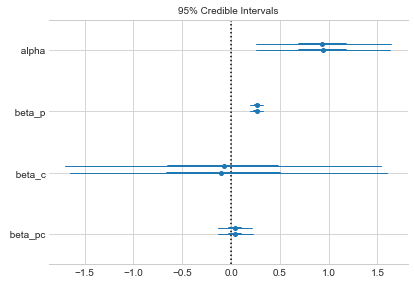

In [22]:
pm.forestplot(model_tools.trace, varnames=['alpha', 'beta_p', 'beta_c', 'beta_pc'], rhat=False)
None

In [7]:
X = 

lam_X = (
    pm.trace_to_dataframe(
        model_tools.trace,
        varnames=['alpha', 'beta_p', 'beta_c', 'beta_pc']
    )
    .apply(
        lambda row: (
            [
                # low contact
                np.exp(row.alpha + row.beta_p * np.log(X)),
                # high contact
                np.exp(row.alpha + row.beta_c + (row.beta_p + row.beta_pc) * np.log(X) )
            ]
        ), 
        axis=1,
        result_type='expand'
    )
    .stack()
    .apply(pd.Series)
    .stack()
    .reset_index()
    .groupby(['level_1', 'level_2'])[0].apply(summarize()).unstack()
)

In [24]:
tmp = agg_prediction(model_tools.trace['lam_test'], test, ['population', 'high_contact'], summarize())

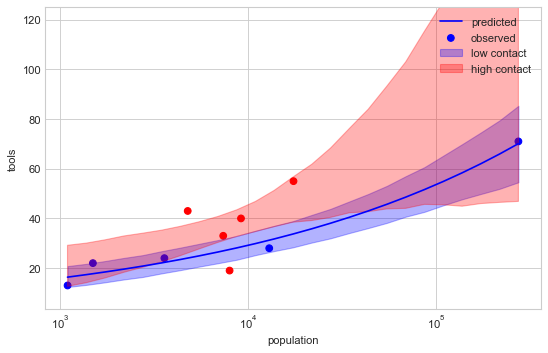

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=80)

color = data.high_contact.map(lambda hc: 'r' if hc else 'b')
ax.scatter(data.population, data.total_tools,
           c=color, label='observed')

ax.plot(tmp[tmp.high_contact==0].population, tmp[tmp.high_contact==0].mean_, c='b', label='predicted')

ax.fill_between(tmp[tmp.high_contact==0].population,
                tmp[tmp.high_contact==0].lower, tmp[tmp.high_contact==0].upper,
                color='b', alpha=.3,
                label='low contact')

ax.fill_between(tmp[tmp.high_contact==1].population,
                tmp[tmp.high_contact==1].lower, tmp[tmp.high_contact==1].upper,
                color='r', alpha=.3,
                label='high contact')

ax.set(xscale='log', xlabel='population', ylabel='tools',
       ylim=(None, 125))
ax.legend()
None